# BLaPE evaluation demo

**☁️ Try it online: [Run the demo directly in Google Colab](https://drive.google.com/file/d/1txVTaIwoqdt0b7VSS80Vj45Vv4nStDQR/view?usp=drive_link) without any setup!**

## Data Loading and Preprocessing

The code below uses the `blape.download_data()` function to download data to the desired path and the `read_data()` function to load wavenumber, raw SERS, and baseline-removed signals. The data is a `dict` type with sample codes as keys, and the BLaPE algorithm is applied to each data sample for preprocessing.

By default, data is downloaded to the `data/` folder in the current directory. After the download is complete, it is recommended to check that `*.csv` files have been created in that path.

This data is provided through Zenodo, so for faster download, you can download the same data through [our GoogleDrive folder](https://drive.google.com/drive/folders/1o4CAkfUIpgeqJb1EIK4ruCsm3VMHinA5?usp=drive_link).

In [1]:
import blape
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Download and load data
blape.download_data(path='data')
data = blape.read_data(path='data')

# Determine the common wavenumber range across all data samples
target_wn = blape.get_common_wavenumber_range(data)
print(f'Common wavenumber range: {target_wn[0]} cm-1 to {target_wn[-1]} cm-1')

# Apply BLaPE algorithm to all samples
print(f'Processing BLaPE...')
pbar = tqdm(data.items())
for code, d in pbar:
    d['blape'] = blape.blape(d['signal'], original_wn=d['wavenumbers'], target_wn=target_wn)
    pbar.set_postfix_str(f"Current sample: {code}")

[=] data\raw already exists → skip
[=] data\baseline_removed already exists → skip
All requested data ready.
Found 376 raw SERS files
Found 376 baseline-removed files
Total raw samples: 17875
Total baseline-removed samples: 17875
Common wavenumber range: 210.679 cm-1 to 1798.35 cm-1
Processing BLaPE...


100%|██████████| 376/376 [00:46<00:00,  8.08it/s, Current sample: P-12-Fe-H288]


## Visualize BLaPE for random sample

Selected sample: U-46-Al-B


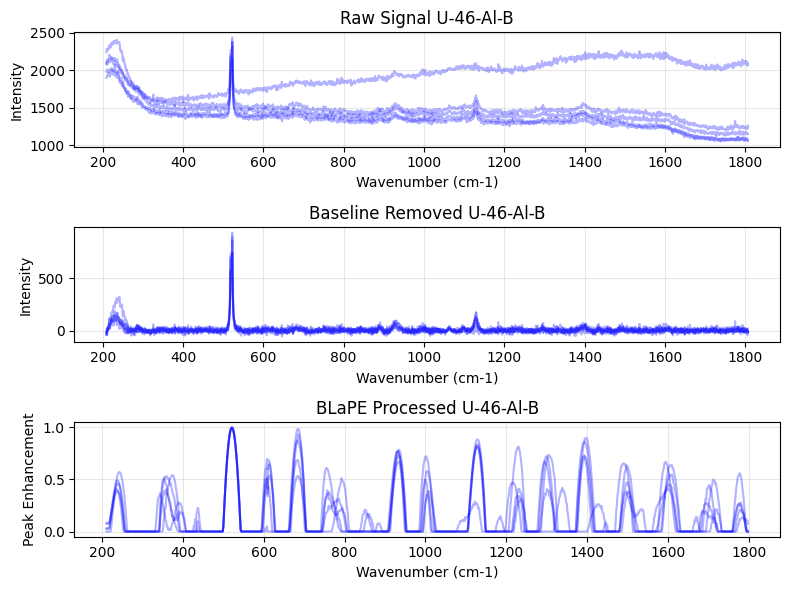

In [10]:
random_code = random.choice(list(data.keys()))
sample = data[random_code]
print(f'Selected sample: {random_code}')

plt.figure(figsize=(8, 6))

# Raw signal
subplot = plt.subplot(3, 1, 1)
plt.plot(sample['wavenumbers'], sample['signal'][:5].T, alpha=0.3, color='b')
plt.title(f'Raw Signal {random_code}')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.grid(True, alpha=0.3)

# Baseline removed
subplot = plt.subplot(3, 1, 2)
plt.plot(sample['wavenumbers'], sample['baseline_removed'][:5].T, alpha=0.3, color='b')
plt.title(f'Baseline Removed {random_code}')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Intensity')
plt.grid(True, alpha=0.3)

# BLaPE processed
subplot = plt.subplot(3, 1, 3)
plt.plot(target_wn, sample['blape'][:5].T, alpha=0.3, color='b')
plt.title(f'BLaPE Processed {random_code}')
plt.xlabel('Wavenumber (cm-1)')
plt.ylabel('Peak Enhancement')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Quick evaluation of BLaPE features

In the following example, we use the default $\sigma = 25$ cm $ ^{-1} $ value to train and evaluate classification models using random forest. We evaluate the accuracy of predicting labels for each of the four categories: base, dye, mordant, and aging condition.

In [3]:
# Quick evaluation of BLaPE features, with default sigma = 25-cm
# Prepare multilabel data
X, y_dict, label_encoders = blape.prepare_multilabel_data(data, feature_key='blape')
print(f"Feature matrix shape: {X.shape}")
print(f"Categories: {list(y_dict.keys())}")

# Show label distribution for each category
for category, labels in y_dict.items():
    unique_labels, counts = np.unique(labels, return_counts=True)
    class_names = label_encoders[category].classes_
    print(f"\n{category} distribution:")
    for i, (label, count) in enumerate(zip(unique_labels, counts)):
        print(f"  {class_names[label]}: {count} samples")

# Train multilabel models
print("\nTraining multilabel classification models...")
models, X_train, X_test, y_train_dict, y_test_dict = blape.train_multilabel_models(
    X, y_dict, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Evaluate models
print("\nEvaluating models...")
results = blape.evaluate_multilabel_models(models, X_test, y_test_dict, label_encoders)

# Print overall accuracy summary
print("\n=== OVERALL ACCURACY SUMMARY ===")
for category, result in results.items():
    print(f"{category}: {result['accuracy']:.3f}")

Feature matrix shape: (17875, 1000)
Categories: ['base', 'dye', 'mordant', 'aging']

base distribution:
  C: 3239 samples
  H: 2553 samples
  P: 3039 samples
  R: 3026 samples
  S: 2952 samples
  U: 3066 samples

dye distribution:
  11: 1905 samples
  12: 2202 samples
  15: 1718 samples
  21: 1028 samples
  22: 2197 samples
  23: 1109 samples
  24: 3403 samples
  32: 829 samples
  33: 766 samples
  46: 226 samples
  51: 1881 samples
  52: 611 samples

mordant distribution:
  Al: 5015 samples
  C: 6289 samples
  Cu: 1231 samples
  Fe: 4185 samples
  K: 1155 samples

aging distribution:
  B: 5976 samples
  H288: 6032 samples
  U288: 5867 samples

Training multilabel classification models...
Training set size: 14300
Test set size: 3575

Evaluating models...

=== BASE Classification Results ===
              precision    recall  f1-score   support

           C       0.71      0.81      0.75       648
           H       0.82      0.67      0.73       511
           P       0.83      0.79  

## Comparison of different regularization methods on `baseline_removed` features

Under the same conditions, we compare the classification performance of different regularization methods (L1, L2, MinMax, StandardNormal) when training random forest on `baseline_removed` features that are not processed by BLaPE. As reported in our paper, the results preprocessed by BLaPE (results from the cell above) are significantly superior to other regularization methods for classical machine learning.

In [5]:
# Interpolate baseline_removed to target_wn for consistent dimensions
pbar = tqdm(data.items())
for code, d in pbar:
    if 'baseline_removed' in d and d['baseline_removed'] is not None:
        baseline_removed_interp = []
        for i in range(d['baseline_removed'].shape[0]):
            interp_spectrum = np.interp(target_wn, d['wavenumbers'], d['baseline_removed'][i])
            baseline_removed_interp.append(interp_spectrum)
        d['baseline_removed_interp'] = np.array(baseline_removed_interp)
    pbar.set_postfix_str(f"Interpolating: {code}")

print("Comparing regularization methods on baseline_removed features...")

regularization_methods = ['l1', 'l2', 'minmax', 'stdnorm']
accuracy_results = {}

for reg_method in regularization_methods:
    print(f"Testing regularization: {reg_method}")
    
    # Prepare data with specific regularization
    X_reg, y_dict_reg, label_encoders_reg = blape.prepare_multilabel_data(
        data, feature_key='baseline_removed_interp', regularization=reg_method
    )
    
    # Train models
    models_reg, X_train_reg, X_test_reg, y_train_dict_reg, y_test_dict_reg = blape.train_multilabel_models(
        X_reg, y_dict_reg, test_size=0.2
    )
    
    # Evaluate models
    results_reg = blape.evaluate_multilabel_models(
        models_reg, X_test_reg, y_test_dict_reg, label_encoders_reg, verbose=False
    )
    
    # Store accuracies
    accuracy_results[reg_method] = {}
    for category, result in results_reg.items():
        accuracy_results[reg_method][category] = result['accuracy']
        
# Display comparison results
print("\n=== REGULARIZATION COMPARISON RESULTS ===")
print("Method\t\tBase\tDye\tMordant\tAging")
print("-" * 50)
for reg_method, accuracies in accuracy_results.items():
    print(f"{reg_method:<10}\t{accuracies['base']:.3f}\t{accuracies['dye']:.3f}\t{accuracies['mordant']:.3f}\t{accuracies['aging']:.3f}")

100%|██████████| 376/376 [00:00<00:00, 807.10it/s, Interpolating: P-12-Fe-H288]


Comparing regularization methods on baseline_removed features...
Testing regularization: l1
Testing regularization: l2
Testing regularization: minmax
Testing regularization: stdnorm

=== REGULARIZATION COMPARISON RESULTS ===
Method		Base	Dye	Mordant	Aging
--------------------------------------------------
l1        	0.599	0.770	0.747	0.669
l2        	0.588	0.759	0.729	0.655
minmax    	0.568	0.778	0.739	0.638
stdnorm   	0.573	0.777	0.736	0.658


## Evaluation of BLaPE with different sigma values

As explained in our paper, the performance of BLaPE depends on the sigma value, and setting this value similar to the bandwidth of actual peaks allows for appropriate noise removal and delivers only important features to the model. Below, we test 10 sigma values in the range of 10~50 cm$^{-1}$ with 5 cm$^{-1}$ intervals to reduce code computation time. However, you can adjust the first line `sigma_values = np.arange(10, 51, 5)` to different intervals and ranges for denser measurements to reproduce the results in the paper.

In [11]:
sigma_values = np.arange(10, 51, 5)  # 10, 15, 20, ..., 50
sigma_results = {}

for sigma in tqdm(sigma_values, desc="Testing sigma values"):
    print(f"Testing sigma: {sigma}")
    
    # Apply BLaPE with different sigma
    for code, d in data.items():
        d['blape_sigma'] = blape.blape(d['signal'], original_wn=d['wavenumbers'], 
                                      target_wn=target_wn, sigma=sigma)
    
    # Prepare data and train models
    X_sigma, y_dict_sigma, label_encoders_sigma = blape.prepare_multilabel_data(
        data, feature_key='blape_sigma', regularization='stdnorm'
    )
    
    models_sigma, X_train_sigma, X_test_sigma, y_train_dict_sigma, y_test_dict_sigma = blape.train_multilabel_models(
        X_sigma, y_dict_sigma, test_size=0.2, random_state=42
    )
    
    results_sigma = blape.evaluate_multilabel_models(
        models_sigma, X_test_sigma, y_test_dict_sigma, label_encoders_sigma, verbose=False
    )
    
    # Store results
    sigma_results[sigma] = {}
    for category, result in results_sigma.items():
        sigma_results[sigma][category] = 1 - result['accuracy']  # Convert to error rate

# Print best sigma for each category
print("\n=== BEST SIGMA FOR EACH CATEGORY ===")
categories = ['base', 'dye', 'mordant', 'aging']
for category in categories:
    best_sigma = min(sigma_results.keys(), key=lambda x: sigma_results[x][category])
    best_error = sigma_results[best_sigma][category]
    best_acc = 1 - best_error
    print(f"{category}: sigma={best_sigma} (accuracy={best_acc:.3f}, error={best_error:.3f})")

Testing sigma values:   0%|          | 0/9 [00:00<?, ?it/s]

Testing sigma: 10


Testing sigma values:  11%|█         | 1/9 [00:53<07:10, 53.81s/it]

Testing sigma: 15


Testing sigma values:  22%|██▏       | 2/9 [02:55<10:57, 93.91s/it]

Testing sigma: 20


Testing sigma values:  33%|███▎      | 3/9 [05:09<11:13, 112.29s/it]

Testing sigma: 25


Testing sigma values:  44%|████▍     | 4/9 [06:32<08:22, 100.44s/it]

Testing sigma: 30


Testing sigma values:  56%|█████▌    | 5/9 [07:26<05:35, 83.92s/it] 

Testing sigma: 35


Testing sigma values:  67%|██████▋   | 6/9 [08:27<03:47, 75.88s/it]

Testing sigma: 40


Testing sigma values:  78%|███████▊  | 7/9 [09:21<02:17, 68.80s/it]

Testing sigma: 45


Testing sigma values:  89%|████████▉ | 8/9 [10:16<01:04, 64.56s/it]

Testing sigma: 50


Testing sigma values: 100%|██████████| 9/9 [11:12<00:00, 74.70s/it]


=== BEST SIGMA FOR EACH CATEGORY ===
base: sigma=35 (accuracy=0.802, error=0.198)
dye: sigma=35 (accuracy=0.903, error=0.097)
mordant: sigma=30 (accuracy=0.878, error=0.122)
aging: sigma=30 (accuracy=0.823, error=0.177)


## Visualization of BLaPE performance with different sigma values

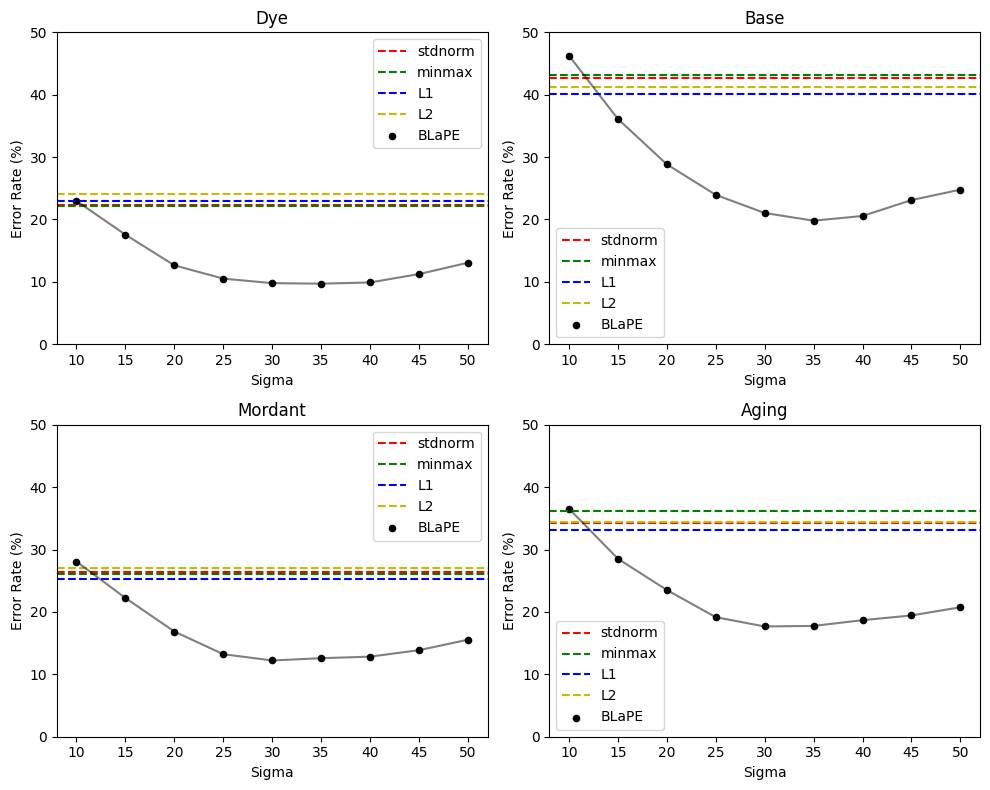

In [12]:
# Calculate mean error rates for each regularization method
reg_mean_errors = {}
for reg_method in regularization_methods:
    reg_mean_errors[reg_method] = {}
    for category in categories:
        reg_mean_errors[reg_method][category] = (1 - accuracy_results[reg_method][category]) * 100

# BLaPE error rates
blape_errors = {}
for category in categories:
    blape_errors[category] = [sigma_results[sigma][category] * 100 for sigma in sigma_results.keys()]

# Plot results
plt.figure(figsize=(10, 8))

# Dye
plt.subplot(221)
plt.axhline(y=reg_mean_errors['stdnorm']['dye'], color='r', linestyle='--', label='stdnorm')
plt.axhline(y=reg_mean_errors['minmax']['dye'], color='g', linestyle='--', label='minmax')
plt.axhline(y=reg_mean_errors['l1']['dye'], color='b', linestyle='--', label='L1')
plt.axhline(y=reg_mean_errors['l2']['dye'], color='y', linestyle='--', label='L2')
plt.scatter(sigma_results.keys(), blape_errors['dye'], label='BLaPE', s=20, color='black')
plt.plot(sigma_results.keys(), blape_errors['dye'], color='black', alpha=0.5)
plt.ylim(0, 50)
plt.title('Dye')
plt.xlabel('Sigma')
plt.ylabel('Error Rate (%)')
plt.legend()

# Base
plt.subplot(222)
plt.axhline(y=reg_mean_errors['stdnorm']['base'], color='r', linestyle='--', label='stdnorm')
plt.axhline(y=reg_mean_errors['minmax']['base'], color='g', linestyle='--', label='minmax')
plt.axhline(y=reg_mean_errors['l1']['base'], color='b', linestyle='--', label='L1')
plt.axhline(y=reg_mean_errors['l2']['base'], color='y', linestyle='--', label='L2')
plt.scatter(sigma_results.keys(), blape_errors['base'], label='BLaPE', s=20, color='black')
plt.plot(sigma_results.keys(), blape_errors['base'], color='black', alpha=0.5)
plt.title('Base')
plt.xlabel('Sigma')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.ylim(0, 50)

# Mordant
plt.subplot(223)
plt.axhline(y=reg_mean_errors['stdnorm']['mordant'], color='r', linestyle='--', label='stdnorm')
plt.axhline(y=reg_mean_errors['minmax']['mordant'], color='g', linestyle='--', label='minmax')
plt.axhline(y=reg_mean_errors['l1']['mordant'], color='b', linestyle='--', label='L1')
plt.axhline(y=reg_mean_errors['l2']['mordant'], color='y', linestyle='--', label='L2')
plt.scatter(sigma_results.keys(), blape_errors['mordant'], label='BLaPE', s=20, color='black')
plt.plot(sigma_results.keys(), blape_errors['mordant'], color='black', alpha=0.5)
plt.title('Mordant')
plt.xlabel('Sigma')
plt.ylabel('Error Rate (%)')
plt.ylim(0, 50)
plt.legend()

# Aging (degradation)
plt.subplot(224)
plt.axhline(y=reg_mean_errors['stdnorm']['aging'], color='r', linestyle='--', label='stdnorm')
plt.axhline(y=reg_mean_errors['minmax']['aging'], color='g', linestyle='--', label='minmax')
plt.axhline(y=reg_mean_errors['l1']['aging'], color='b', linestyle='--', label='L1')
plt.axhline(y=reg_mean_errors['l2']['aging'], color='y', linestyle='--', label='L2')
plt.scatter(sigma_results.keys(), blape_errors['aging'], label='BLaPE', s=20, color='black')
plt.plot(sigma_results.keys(), blape_errors['aging'], color='black', alpha=0.5)
plt.title('Aging')
plt.xlabel('Sigma')
plt.ylabel('Error Rate (%)')
plt.ylim(0, 50)
plt.legend()

plt.tight_layout()
plt.show()